In [15]:
import datasets
import os
import openai

In [16]:
client = openai.Client(api_key=os.environ["OPENAI_API_KEY"])

In [60]:
ds = datasets.load_dataset("cassanof/orm_dataset_raw10_og", split="train")
ds = ds.shuffle()
ds

Dataset({
    features: ['unique_name', 'prompt', 'starter_code', 'difficulty', 'results'],
    num_rows: 13402
})

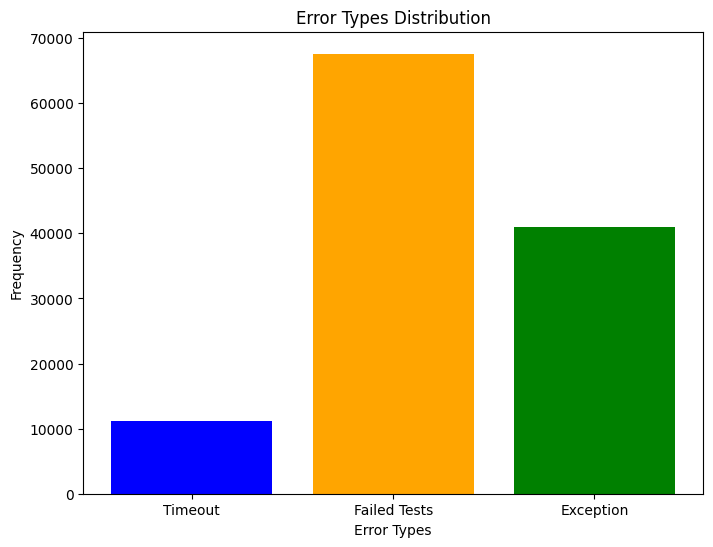

In [28]:
import matplotlib.pyplot as plt
def get_err_kind(r):
    o = r["output"]
    if "Timeout" in o:
        t = "Timeout"
    elif "expected" in o and "but got" in o or "AssertionError" in o:
        t = "Failed Tests"
    else:
        t = "Exception"
    return t
    
errs = [] # err types: "Timeout", "Exception", "Failed Tests"
for ex in ds:
    for r in ex["results"]:
        if not r["passing"]:
            errs.append(get_err_kind(r))

error_counts = {error: errs.count(error) for error in set(errs)}

error_types = list(error_counts.keys())
counts = list(error_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(error_types, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Error Types')
plt.ylabel('Frequency')
plt.title('Error Types Distribution')
plt.show()

In [58]:
from codeprm.prompts import py_prompt
import random
random.seed(42)
check_size = 5000
samples = []
for ex in ds.select(range(check_size)):
    r = random.choice(ex["results"])
    code = r["code"]
    code = ex["starter_code"] + code
    code = py_prompt(ex["prompt"], code)
    r["code"] = code
    samples.append(r)
print(samples[100]["code"])

"""
Pasha has many hamsters and he makes them work out. Today, n hamsters (n is even) came to work out. The hamsters lined up and each hamster either sat down or stood up.

For another exercise, Pasha needs exactly $\frac{n}{2}$ hamsters to stand up and the other hamsters to sit down. In one minute, Pasha can make some hamster ether sit down or stand up. How many minutes will he need to get what he wants if he acts optimally well?


-----Input-----

The first line contains integer n (2 ≤ n ≤ 200; n is even). The next line contains n characters without spaces. These characters describe the hamsters' position: the i-th character equals 'X', if the i-th hamster in the row is standing, and 'x', if he is sitting.


-----Output-----

In the first line, print a single integer — the minimum required number of minutes. In the second line, print a string that describes the hamsters' position after Pasha makes the required changes. If there are multiple optimal positions, print any of them.


---

In [62]:
from tqdm import tqdm
code = samples[0]["code"]
def gpt_classifier(code, model="gpt-4o"):
    system = "You are a champion competitive programmer. You are able to identify if an algorithmic solution to a problem is either correct or not. You will respond only with Yes or No, then, only after the Yes/No, you will provide a very brief explaination of why."
    resp = client.chat.completions.create(
        model=model,
        temperature=0.0,
        messages=[
            {
                "role": "system",
                "content": system,
            },
            {
                "role": "user",
                "content": f"Please respond with Yes or No if the given program is correct or not, then after the newline, very briefly explain why:\n{code}",
            }
        ]
    )
    split = resp.choices[0].message.content.split("\n")
    if len(split) < 2:
        return None
    split = [s for s in split if s.strip() != ""]
    cls = split[0].strip()
    exp = "\n".join(split[1:])
    if cls != "Yes" and cls != "No":
        return None
    if cls == "Yes":
        cls_b = True
    elif cls == "No":
        cls_b = False
    return cls_b, exp

new_ds = datasets.Dataset.from_list(samples)
cls = [None] * len(samples)
exp = [None] * len(samples)
new_ds = new_ds.add_column("cls", cls)
new_ds = new_ds.add_column("exp", exp)

def run_cls(ex):
    code = ex["code"]
    out = gpt_classifier(code)
    if out is not None:
        cls, exp = out
        return {"cls": cls, "exp": exp}

new_ds = new_ds.map(run_cls, num_proc=96)

Map (num_proc=96): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.06 examples/s]


In [64]:
bad_cls = 0
agreement = 0
disagrees_on_passing = 0
disagrees_on_failing = 0
disagrees = []
for ex in new_ds:
    cls = ex["cls"]
    p = ex["passing"]
    
    if cls is None:
        bad_cls += 1
        continue
        
    if cls == p:
        agreement += 1
    else:
        if p:
            disagrees_on_passing += 1
        else:
            disagrees_on_failing += 1
        disagrees.append(ex)

print(f"Agreement rate: {agreement / len(new_ds)}")
print(f"Disagrees on tests passing: {disagrees_on_passing / len(disagrees)}")
print(f"Disagrees on tests failing: {disagrees_on_failing / len(disagrees)}")

Agreement rate: 0.9066
Disagrees on tests passing: 0.7387580299785867
Disagrees on tests failing: 0.26124197002141325
